In [2]:
%pip install pip install opencv-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.6 MB 9.3 MB/s eta 0:00:05
    --------------------------------------- 0.7/38.6 MB 8.2 MB/s eta 0:00:05
   - -------------------------------------- 1.0/38.6 MB 7.9 MB/s eta 0:00:05
   - -------------------------------------- 1.3/38.6 MB 8.2 MB/s eta 0:00:05
   -- ------------------------------------- 2.0/38.6 MB 9.3 MB/s eta 0:00:04
   -- ------------------------------------- 2.6/38.6 MB 9.7 MB/s eta 0:00:04
   --- ------------------------------------ 3.0/38.6 MB 9.5 MB/s eta 0:00:04
   --- ------------------------------------ 3.4/38.6 MB 9.3 MB/s eta 0:00:04
   --- ------------------------------------ 3.8/38.6 MB 9.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.2/38.6 MB 9.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.8/38.6 MB 9.5 MB/s eta 0:00:04
   ----- ---------------------------------- 5.3/38.6 MB 9.3 MB/s eta 0:00:04
   --

In [3]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

C:\Users\Mrudula\AppData\Local\Temp\ipykernel_3160\183779410.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
#from skimage import io
from tqdm import tqdm

In [7]:
mydir = 'CoffeeBeanQualityData/train/'

In [8]:
categories = ['Green','Light','Medium','Dark']
data =[]
for i in categories:
  folder_path = os.path.join(mydir,i)
  if(i=='Green'):
    label = 0
  elif(i=='Light'):
    label = 1
  elif(i=='Medium'):
    label = 2
  else:
    label = 3
  for j in os.listdir(folder_path):
    img_path = os.path.join(folder_path, j)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224, 224))
    data.append([img,label])

In [13]:
import random
random.shuffle(data)

In [14]:
x=[]
y=[]

for i in data:
  x.append(i[0])
  y.append(i[1])

In [15]:
y = np.array(y)
x = np.array(x)

Load Images in Data Generator

In [19]:
image_size = (224, 224)
batch_size = 64
datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range=45,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.25,
            zoom_range=0.25,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect',
            validation_split = 0.1)

In [20]:
train_ds = datagen.flow_from_directory(mydir,
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = datagen.flow_from_directory(mydir,
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 1080 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [21]:
train_ds.class_indices

{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

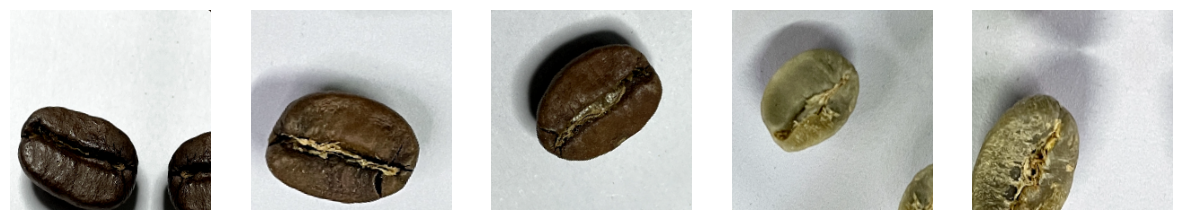

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

In [23]:
from keras import applications

In [24]:
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False



58889256/58889256 [==============================] - 5s 0us/step


In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout

In [26]:
inputs = Input(shape=(224, 224, 3))

x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation = 'sigmoid')(x)
vgg_model = Model(inputs, outputs)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                             

In [27]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [28]:
epochs = 25
vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds)
vgg_model.save('vgg.hdf5') #this saves the model with the weights

Epoch 1/25


C:\Users\Mrudula\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



17/17 [==============================] - 296s 16s/step - loss: 1.3752 - categorical_accuracy: 0.3306 - val_loss: 1.2655 - val_categorical_accuracy: 0.3167
Epoch 2/25
17/17 [==============================] - 276s 15s/step - loss: 1.1572 - categorical_accuracy: 0.4991 - val_loss: 1.1226 - val_categorical_accuracy: 0.5167
Epoch 3/25
17/17 [==============================] - 235s 14s/step - loss: 0.9645 - categorical_accuracy: 0.6333 - val_loss: 0.9940 - val_categorical_accuracy: 0.6917
Epoch 4/25
17/17 [==============================] - 241s 14s/step - loss: 0.8506 - categorical_accuracy: 0.6796 - val_loss: 0.9919 - val_categorical_accuracy: 0.5667
Epoch 5/25
17/17 [==============================] - 205s 12s/step - loss: 0.7825 - categorical_accuracy: 0.6917 - val_loss: 0.9071 - val_categorical_accuracy: 0.6583
Epoch 6/25
17/17 [==============================] - 262s 16s/step - loss: 0.6883 - categorical_accuracy: 0.7574 - val_loss: 0.8594 - val_categorical_accuracy: 0.6667
Epoch 7/25
17/

C:\Users\Mrudula\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [67]:
my_testdir = 'CoffeeBeanQualityData/test/'

In [74]:
categories = ['Green','Light','Medium','Dark']
data_test =[]
for i in categories:
  folder_path = os.path.join(my_testdir,i)
  if(i=='Dark'):
    label = 0
  elif(i=='Green'):
    label = 1
  elif(i=='Light'):
    label = 2
  else:
    label = 3
  for j in os.listdir(folder_path):
    img_path = os.path.join(folder_path, j)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224, 224))
    data_test.append([img,label])

In [75]:
import random
random.shuffle(data_test)

In [76]:
x_test=[]
y_test=[]

for i in data_test:
  x_test.append(i[0])
  y_test.append(i[1])

In [77]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [78]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

1/1 [==============================] - 0s 183ms/step
The given image is of 
Class: 2 
Species: Light


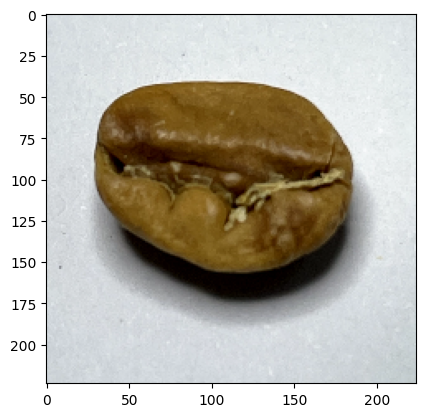

In [88]:
predictor('CoffeeBeanQualityData/test/Light/light (46).png', vgg_model)

1/1 [==============================] - 0s 162ms/step
The given image is of 
Class: 3 
Species: Medium


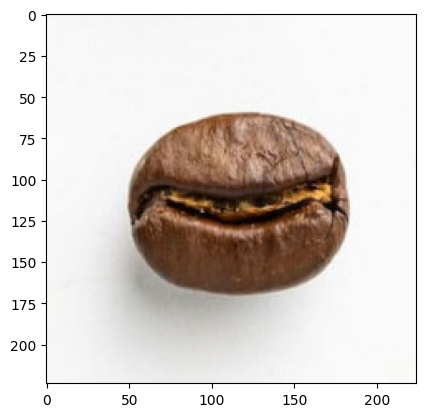

In [90]:
predictor('medium-roast-coffee-bean.jpg', vgg_model)

Frontend

In [5]:
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
%%writefile app.py
import streamlit as st
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache_data
def load_model():
  model = tf.keras.models.load_model('vgg.hdf5')
  return model

st.write("""   # Coffee Bean Quality Prediction App""")

file = st.file_uploader("Please upload an image file", type=["jpg", "png"])

import cv2
import numpy as np
from PIL import Image, ImageOps

def import_and_predict(image_data, model):
    size = (224, 224)
    image = ImageOps.fit(image_data, size)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = np.array(image, dtype = 'float32')/255.0
    #img = np.asarray(image)
    img_reshape = img[np.newaxis, ...]
    prediction = model.predict(img_reshape)
    return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model=load_model())
    class_names = ['Dark', 'Green', 'Light', 'Medium']
    string = "This image most likely is: " + class_names[np.argmax(predictions)]
    st.success(string)

Overwriting app.py
